In [1]:
import plot
import importlib
import numpy as np
import random
import os
import glob
import h5py
import math
import scipy
import random
import classify
import warnings
import preprocess
import matplotlib
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from os import path
from scipy import stats
from scipy.io import loadmat
from matplotlib import gridspec
from numpy.linalg import norm
from scipy.spatial import distance
from sklearn import decomposition
from matplotlib.colors import LinearSegmentedColormap
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
warnings.filterwarnings('ignore')
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

np.random.seed(42)
random.seed(42)


ModuleNotFoundError: No module named 'plot'

In [3]:
# reload when updating code
importlib.reload(preprocess)
# mouse and date

mice = ['NN11'] 
dates_per_mouse = {'NN11': ['210626']}

for mouse in mice:
    dates = dates_per_mouse[mouse]  # Get the list of dates for the current mouse
    days = len(dates)  # Correct number of days for this mouse
    
    for day_idx, date in enumerate(dates):
        print(mouse, date)
        
        # Create folders to save files
        paths = preprocess.create_folders(mouse, date)
        print('folders created')
        
        # Import data for mouse and date as dict
        session_data = preprocess.load_data(paths)
        print('data loaded')
        
        # Process and plot behavior
        behavior = preprocess.process_behavior(session_data, paths)
        print('behavior done')
        
        # Save masks so can run in Matlab to process other planes
        # preprocess.cell_masks(paths, 0)
        print('masks saved')
        
        # Grab activity
        deconvolved = preprocess.process_activity(paths, 'spks', 3, 0)
        print('activity processed')
        
        # Normalize activity
        norm_deconvolved = preprocess.normalize_deconvolved(deconvolved, behavior, paths, 0)
        print('activity normalized')
        
        # Gaussian filter activity
        norm_moving_deconvolved_filtered = preprocess.difference_gaussian_filter(norm_deconvolved, 4, behavior, paths, 0)
        print('activity filtered')
        
        # Make trial-averaged traces and baseline subtract
        mean_cs_1_responses_df = preprocess.normalized_trial_averaged(norm_deconvolved, behavior, 'cs_1')
        mean_cs_2_responses_df = preprocess.normalized_trial_averaged(norm_deconvolved, behavior, 'cs_2')
        print('traces done')
        
        # Get significant cells
        [cs_1_poscells, cs_1_negcells] = preprocess.sig_test(norm_deconvolved, behavior, 'cs_1')
        [cs_2_poscells, cs_2_negcells] = preprocess.sig_test(norm_deconvolved, behavior, 'cs_2')
        [both_poscells, both_sigcells] = preprocess.combine_sig(cs_1_poscells, cs_1_negcells, cs_2_poscells, cs_2_negcells)
        print('sig cells done')
        
        # Get index of top cell differences
        idx = preprocess.get_index(behavior, mean_cs_1_responses_df, mean_cs_2_responses_df, cs_1_poscells, cs_2_poscells, both_poscells, both_sigcells, paths, 1)
        print('idx done')
        
        # Get prior for synchronous cue activity
        prior = classify.prior(norm_moving_deconvolved_filtered, idx['cs_1'], idx['cs_2'], behavior, [])
        print('prior done')
        
        # Logistic regression
        y_pred_log = classify.log_regression(behavior, norm_deconvolved, norm_moving_deconvolved_filtered, both_poscells, prior)
        print('logistic regression done')
        
        # Process classified output
        y_pred = classify.process_classified(y_pred_log, prior, paths, 1)
        print('classified done')
    


NN11 210626
folders created
data loaded
behavior done
masks saved
activity processed
activity normalized
activity filtered
traces done
sig cells done
idx done
prior done
logistic regression done
classified done


In [4]:
print(norm_moving_deconvolved_filtered.shape)

(6779, 106665)


In [5]:
activity = norm_deconvolved.to_numpy()
activity = activity[idx['both'].index]

# Commented out code for filtering significant reactivated cells.
# sig_cells = preprocess.sig_reactivated_cells([], [], [], [], [], paths, 0)
# activity = activity[sig_cells > 0, :]

# Initialize lists to store mean activities and onsets for two different cues.
mean_activity_cs_1 = []
mean_activity_cs_2 = []
mean_activity_cs_any = []
onsets_cs_1 = []
onsets_cs_2 = []

# Loop over each onset and offset in behavior data.
for i in range(0, len(behavior['onsets'])):
    # Calculate the mean activity for the given onset to offset period.
    temp_activity = np.mean(activity[:, int(behavior['onsets'][i]):int(behavior['offsets'][i]) + 1], axis=1)
    # Check if the cue code matches cs_1_code, and store the mean activity and onset.
    if behavior['cue_codes'][i] == behavior['cs_1_code']:
        mean_activity_cs_1.append(temp_activity)
        onsets_cs_1.append(behavior['onsets'][i])
        mean_activity_cs_any.append(temp_activity)
    # Check if the cue code matches cs_2_code, and store the mean activity and onset.
    if behavior['cue_codes'][i] == behavior['cs_2_code']:
        mean_activity_cs_2.append(temp_activity)
        onsets_cs_2.append(behavior['onsets'][i])
        mean_activity_cs_any.append(temp_activity)

cos_sim = lambda a, b: np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))
topn = 0.05

# Commented out code for filtering significant reactivated cells.
# sig_cells = preprocess.sig_reactivated_cells([], [], [], [], [], paths, 0)
# activity = activity[sig_cells > 0, :]

# Initialize lists to store mean activities and onsets for two different cues.
mean_activity_cs_1 = []
mean_activity_cs_2 = []
mean_activity_cs_any = []
onsets_cs_1 = []
onsets_cs_2 = []

# Loop over each onset and offset in behavior data.
for i in range(0, len(behavior['onsets'])):
    # Calculate the mean activity for the given onset to offset period.
    temp_activity = np.mean(activity[:, int(behavior['onsets'][i]):int(behavior['offsets'][i]) + 1], axis=1)
    # Check if the cue code matches cs_1_code, and store the mean activity and onset.
    if behavior['cue_codes'][i] == behavior['cs_1_code']:
        mean_activity_cs_1.append(temp_activity)
        onsets_cs_1.append(behavior['onsets'][i])
        mean_activity_cs_any.append(temp_activity)
    # Check if the cue code matches cs_2_code, and store the mean activity and onset.
    if behavior['cue_codes'][i] == behavior['cs_2_code']:
        mean_activity_cs_2.append(temp_activity)
        onsets_cs_2.append(behavior['onsets'][i])
        mean_activity_cs_any.append(temp_activity)

# Normalize the mean activities for each trial.
mean_activity_cs_1 = mean_activity_cs_1 / np.mean(mean_activity_cs_any, axis=0)
mean_activity_cs_2 = mean_activity_cs_2 / np.mean(mean_activity_cs_any, axis=0)

mean_activity_cs_1 = np.stack(mean_activity_cs_1, axis=0)
mean_activity_cs_2 = np.stack(mean_activity_cs_2, axis=0)

# Calculate the mean of the first and last three mean activities for cs_1 and cs_2.
n_centroids = 3
mean_activity_cs_1_mean = [np.mean(mean_activity_cs_1[0:n_centroids], axis=0), np.mean(mean_activity_cs_1[len(mean_activity_cs_1) - n_centroids:len(mean_activity_cs_1)], axis=0)]
mean_activity_cs_2_mean = [np.mean(mean_activity_cs_2[0:n_centroids], axis=0), np.mean(mean_activity_cs_2[len(mean_activity_cs_2) - n_centroids:len(mean_activity_cs_2)], axis=0)]

# Calculate the difference vectors between the early and late mean activities for cs_1 and cs_2.
mean_activity_cs_1_vec = mean_activity_cs_1_mean[1] - mean_activity_cs_1_mean[0]
mean_activity_cs_2_vec = mean_activity_cs_2_mean[1] - mean_activity_cs_2_mean[0]

late_trails_1 = mean_activity_cs_1_mean[1]
top_n_percent_indices_1 = np.argsort(late_trails_1)[-int(len(late_trails_1) * topn):]
mean_activity_cstopn_1 = mean_activity_cs_1[:, top_n_percent_indices_1]
mean_activity_cstopn_1_late = mean_activity_cs_1_mean[1][top_n_percent_indices_1]

late_trails_2 = mean_activity_cs_2_mean[1]
top_n_percent_indices_2 = np.argsort(late_trails_2)[-int(len(late_trails_2) * topn):]
mean_activity_cstopn_2 = mean_activity_cs_2[:, top_n_percent_indices_2]
mean_activity_cstopn_2_late = mean_activity_cs_2_mean[1][top_n_percent_indices_2]

sim_cs_1 = np.zeros(len(mean_activity_cs_1))
sim_cs_2 = np.zeros(len(mean_activity_cs_2))

# Normalize the mean activities for each trial using the difference vectors.
for i in range(0, len(mean_activity_cs_1)):
    sim_cs_1[i] = cos_sim(mean_activity_cstopn_1[i], mean_activity_cstopn_1_late)
    # sim_cs_1[i] = cos_sim(mean_activity_cs_1[i], mean_activity_cs_1_mean[1])
    # sim_cs_1[i] = np.dot(mean_activity_cs_1[i], mean_activity_cs_1_vec) / np.linalg.norm(mean_activity_cs_1_vec)
for i in range(0, len(mean_activity_cs_2)):
    sim_cs_2[i] = cos_sim(mean_activity_cstopn_2[i], mean_activity_cstopn_2_late)
    # sim_cs_2[i] = cos_sim(mean_activity_cs_2[i], mean_activity_cs_2_mean[1])
    # sim_cs_2[i] = np.dot(mean_activity_cs_2[i], mean_activity_cs_2_vec) / np.linalg.norm(mean_activity_cs_2_vec)


# Initialize lists to store mean activities and trial indices for reactivation events.
mean_activity_r_1 = []
mean_activity_r_2 = []
mean_activity_r_any = []
trial_r_1 = []
trial_r_2 = []

# Copy reactivation predictions for cs_1 and cs_2.
reactivation_cs_1 = y_pred[:, 0].copy()
reactivation_cs_2 = y_pred[:, 1].copy()

# Set a threshold for reactivation probability.
p_threshold = .75

# Initialize variables for reactivation event detection.
cs_1_peak = 0
cs_2_peak = 0
i = 0
next_r = 0

# Loop through reactivation predictions to detect reactivation events.
while i < len(reactivation_cs_1) - 1:
    # Check if there is a reactivation event.
    if reactivation_cs_1[i] > 0 or reactivation_cs_2[i] > 0:
        if next_r == 0:
            r_start = i
            next_r = 1
        # Update peak reactivation values.
        if reactivation_cs_1[i] > cs_1_peak:
            cs_1_peak = reactivation_cs_1[i]
        if reactivation_cs_2[i] > cs_2_peak:
            cs_2_peak = reactivation_cs_2[i]
        #print(reactivation_cs_1[i + 1], reactivation_cs_2[i + 1])
        # Check if the reactivation event has ended.
        if reactivation_cs_1[i + 1] <= 0.001 and reactivation_cs_2[i + 1]<= 0.001:
            r_end = i + 1
            next_r = 0
            # Store mean activity and trial index for cs_1 reactivation events above the threshold.
            if cs_1_peak > p_threshold:
                for j in range(0, len(onsets_cs_1)):
                    if r_start < onsets_cs_1[j] and r_start > onsets_cs_1[j-1] and r_start < onsets_cs_1[j-1] + int(behavior['framerate']*61):
                        mean_activity_r_1.append(np.mean(activity[:, r_start:r_end], axis=1))
                        trial_r_1.append(j-1)
                        mean_activity_r_any.append(np.mean(activity[:, r_start:r_end], axis=1))
                        break
            # Store mean activity and trial index for cs_2 reactivation events above the threshold.
            if cs_2_peak > p_threshold:
                for j in range(0, len(onsets_cs_2)):
                    if r_start < onsets_cs_2[j] and r_start > onsets_cs_2[j-1] and r_start < onsets_cs_2[j-1] + int(behavior['framerate']*61):
                        mean_activity_r_2.append(np.mean(activity[:, r_start:r_end], axis=1))
                        trial_r_2.append(j-1)
                        mean_activity_r_any.append(np.mean(activity[:, r_start:r_end], axis=1))
                        break
            # Reset variables for the next reactivation event.
            i = r_end
            cs_1_peak = 0
            cs_2_peak = 0
    i += 1


# Normalize the reactivation mean activities.
mean_activity_r_1 = mean_activity_r_1 / np.mean(mean_activity_r_any, axis=0)
mean_activity_r_2 = mean_activity_r_2 / np.mean(mean_activity_r_any, axis=0)

mean_activity_r_1 = np.stack(mean_activity_r_1, axis=0)
mean_activity_r_2 = np.stack(mean_activity_r_2, axis=0)

# mean_activity_rtopn_1 = mean_activity_r_1[:, top_n_percent_indices_1]
# mean_activity_cstopn_1_late = mean_activity_cs_1_mean[1][top_n_percent_indices_1]

# mean_activity_rtopn_2 = mean_activity_r_2[:, top_n_percent_indices_2]
# mean_activity_cstopn_2_late = mean_activity_cs_2_mean[1][top_n_percent_indices_2]

sim_r_1 = np.zeros(len(mean_activity_r_1))
sim_r_2 = np.zeros(len(mean_activity_r_2))

sim_r_1_random = np.zeros(len(mean_activity_r_1))

zero_indices = np.where(mean_activity_r_1 != 0)
    
# Normalize the reactivation mean activities using the difference vectors.
for i in range(0, len(mean_activity_r_1)):
    # nonzero_indices = np.where(mean_activity_r_1[i] != 0)
    top_n_percent_indices_r_1 = np.argsort(mean_activity_r_1[i])[-int(len(mean_activity_r_1[i]) * topn):]
    sim_r_1[i] = cos_sim(mean_activity_r_1[i][np.intersect1d(top_n_percent_indices_r_1, top_n_percent_indices_1)], mean_activity_cs_1_mean[1][np.intersect1d(top_n_percent_indices_r_1, top_n_percent_indices_1)])
    
    chosen_indices = np.random.randint(0, len(mean_activity_r_1[i]), 27)
    sim_r_1_random[i] = cos_sim(mean_activity_r_1[i][chosen_indices], mean_activity_cs_1_mean[1][chosen_indices])
    # sim_r_1[i] = cos_sim(mean_activity_rtopn_1[i], mean_activity_cstopn_1_late)
    # sim_r_1[i] = cos_sim(mean_activity_r_1[i], mean_activity_cs_1_mean[1])
    # sim_r_1[i] = np.dot(mean_activity_r_1[i], mean_activity_cs_1_vec) / np.linalg.norm(mean_activity_cs_1_vec)
for i in range(0, len(mean_activity_r_2)):
    # nonzero_indices = np.where(mean_activity_r_2[i] != 0)
    top_n_percent_indices_r_2 = np.argsort(mean_activity_r_2[i])[-int(len(mean_activity_r_2[i]) * topn):]
    sim_r_2[i] = cos_sim(mean_activity_r_2[i][np.intersect1d(top_n_percent_indices_r_2, top_n_percent_indices_2)], mean_activity_cs_2_mean[1][np.intersect1d(top_n_percent_indices_r_2, top_n_percent_indices_2)])
    # sim_r_2[i] = cos_sim(mean_activity_rtopn_2[i], mean_activity_cstopn_2_late)
    # sim_r_2[i] = cos_sim(mean_activity_r_2[i], mean_activity_cs_2_mean[1])
    # sim_r_2[i] = np.dot(mean_activity_r_2[i], mean_activity_cs_2_vec) / np.linalg.norm(mean_activity_cs_2_vec)



In [11]:
print(trial_r_1)
print(trial_r_2)
print(onsets_cs_1)
for i in range(0, len(behavior['onsets'])):
        print(behavior['cue_codes'][i])


[1, 1, 1, 2, 2, 2, 3, 3, 4, 5, 5, 7, 8, 8, 9, 9, 10, 10, 11, 11, 12, 12, 12, 12, 12, 13, 13, 13, 14, 14, 14, 15, 15, 15, 16, 16, 17, 17, 18, 18, 19, 19, 19, 20, 20, 21, 21, 21, 23, 24, 25, 25, 26, 26, 27, 28, 29, 29, 29, 30, 30, 30, 30, 31, 33, 34, 34, 34, 35, 36, 37, 38, 39, 39, 40, 40, 41, 41, 42, 42, 43, 44, 44, 45, 45, 46, 47, 48, 50, 51, 52, 52, 52, 53, 53, 54, 54, 54, 55, 55, 55, 55, 56, 57, 57, 57, 57, 58, 58, 58, 58, 58, 59, 59, 59, 60, 60, 61, 61, 61, 62, 62, 62, 62, 63, 63, 64, 64, 64, 65, 65, 65, 65, 65, 65, 66, 66, 66, 66]
[0, 1, 1, 1, 2, 3, 3, 3, 4, 5, 5, 6, 6, 7, 7, 8, 8, 8, 9, 9, 10, 11, 11, 11, 12, 12, 13, 13, 14, 14, 15, 15, 16, 17, 18, 18, 18, 19, 19, 21, 22, 22, 23, 24, 25, 26, 26, 26, 26, 27, 27, 28, 28, 28, 29, 29, 29, 30, 30, 31, 31, 31, 32, 32, 33, 33, 34, 35, 38, 40, 40, 41, 41, 41, 42, 43, 43, 44, 45, 45, 46, 47, 48, 48, 49, 49, 49, 49, 50, 50, 51, 52, 52, 52, 53, 53, 54, 55, 55, 55, 56, 57, 57, 57, 57, 57, 57, 58, 58, 58, 58]
[array([21833]), array([22456]), a

In [160]:
def compute_sign_changes(mean_activity_cs, trial_r):
    """
    Compute sign changes based on trial-to-trial differences and map them to reactivations.
    
    Parameters:
    - mean_activity_cs: Trial-level activity (shape: trials x neurons)
    - trial_r: Reactivation-to-trial mapping (shape: reactivations,)
    
    Returns:
    - sign_changes: Array of sign changes mapped to reactivations (-1 or +1) for each neuron.
    """
    
    # Compute trial-to-trial differences
    trial_diff = np.diff(mean_activity_cs, axis=0)  # Shape: (trials-1, neurons)
    
    # Compute signs of trial differences
    trial_sign_changes = np.where(trial_diff > 0, 1, -1)  # Shape: (trials-1, neurons)

    # Map trial-level changes to reactivations, exclude last reactivation for shape match
    reactivation_sign_changes = trial_sign_changes[trial_r] 

    return reactivation_sign_changes

def clean_and_prepare_data(mean_activity_r, mean_activity_cs, trial_r):
    """
    Prepare predictors (X) and targets (y) for logistic regression ensuring correct trial-to-trial differences.
    
    Parameters:
    - mean_activity_r: Reactivation-level activity (shape: reactivations x neurons).
    - mean_activity_cs: Trial-level activity (shape: trials x neurons).
    - trial_r: Reactivation-to-trial mapping (shape: reactivations,).
    
    Returns:
    - X_all: Combined predictors (reactivation activity) for sensory evoked response (shape: total_reactivations, neurons).
    - y_all: Combined targets (sign changes) for all neurons (shape: total_reactivations, neurons).
    """
    X_list = []  # Predictors for all neurons
    y_list = []  # Targets for all neurons
    
    # Compute targets for all neurons
    for neuron in range(mean_activity_cs_1.shape[1]):
        y_neuron = compute_sign_changes(mean_activity_cs[:, neuron], trial_r)
        y_list.append(y_neuron)
    
    # Prepare predictors for the subset of neurons
    for neuron in range(mean_activity_r.shape[1]):
        # Adjust reactivation activity by subtracting the SER activity
        X_neuron = mean_activity_r[:, neuron] - mean_activity_cs[trial_r, neuron]
        X_list.append(X_neuron)
    
    # Stack all predictors and targets
    X_all = np.column_stack(X_list)  # Shape: (total_reactivations, subset_neurons)
    y_all = np.column_stack(y_list)  # Shape: (total_reactivations, total_neurons)
        
    return X_all, y_all

X_cs_1, y_cs_1_clean = clean_and_prepare_data(mean_activity_r_1, mean_activity_cs_1, trial_r_1)
X_cs_2, y_cs_2_clean = clean_and_prepare_data(mean_activity_r_2, mean_activity_cs_2, trial_r_2)

# Combine the datasets
X_all = np.concatenate([X_cs_1, X_cs_2])  # Shape: (total_reactivations, neurons)
y_all = np.concatenate([y_cs_1_clean, y_cs_2_clean]) 

print(X_all.shape, y_all.shape)

# Sanity check the processed targets
unique_cs_1, counts_cs_1 = np.unique(y_cs_1_clean, return_counts=True)
unique_cs_2, counts_cs_2 = np.unique(y_cs_2_clean, return_counts=True)

print("Processed Targets for CS_1:")
print(dict(zip(unique_cs_1, counts_cs_1)))
print("\nProcessed Targets for CS_2:")
print(dict(zip(unique_cs_2, counts_cs_2)))

(250, 3124) (250, 3124)
Processed Targets for CS_1:
{-1: 216563, 1: 217673}

Processed Targets for CS_2:
{-1: 173997, 1: 172767}



=== Cross-Validation Summary ===
Accuracy:  0.858 ± 0.047
Precision: 0.858
Recall:    0.861
F1-score:  0.856


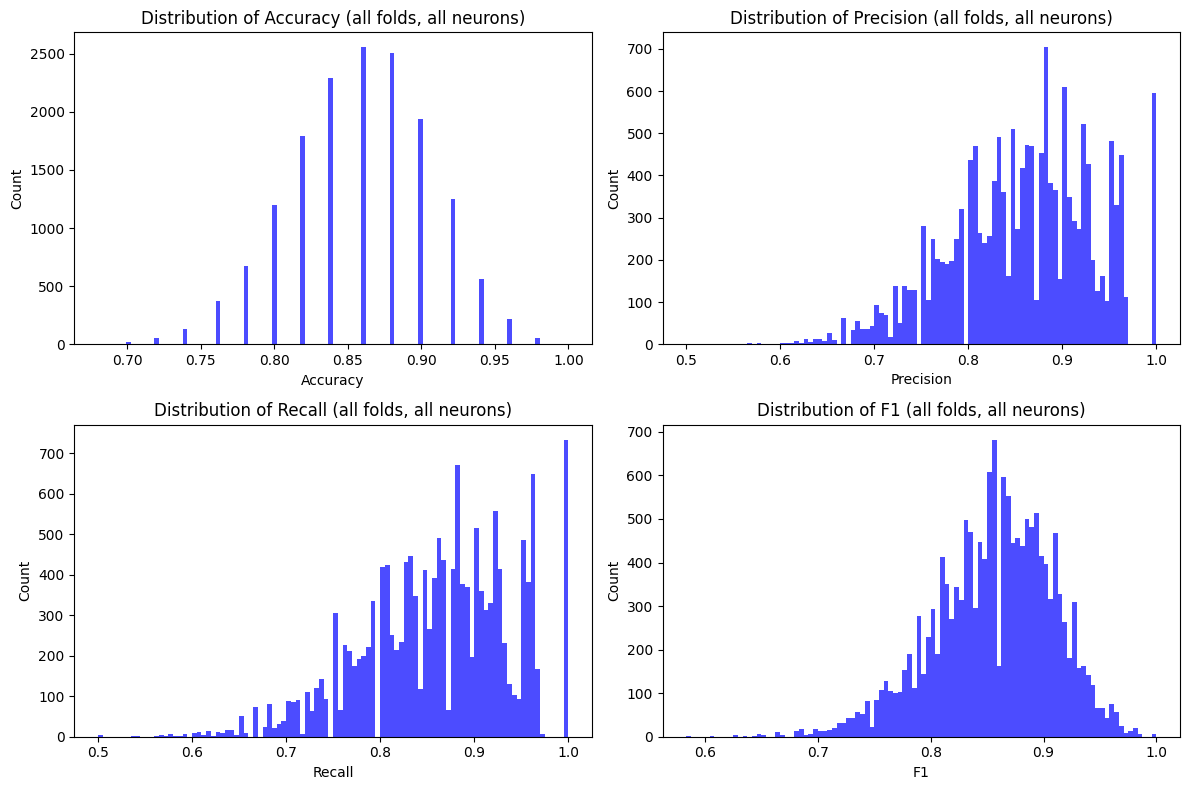

In [167]:
from sklearn.linear_model import LogisticRegression
from sklearn.multioutput import MultiOutputClassifier
from sklearn.model_selection import KFold
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score
)
from joblib import Parallel, delayed
import numpy as np


def evaluate_fold(model, X_train, X_test, y_train, y_test):
    """Trains the model and evaluates metrics for a single CV fold."""
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    # Compute metrics for each output (neuron)
    fold_accuracies = []
    fold_precisions = []
    fold_recalls = []
    fold_f1s = []

    for neuron_idx in range(y_test.shape[1]):
        y_test_n = y_test[:, neuron_idx]
        y_pred_n = y_pred[:, neuron_idx]

        fold_accuracies.append(accuracy_score(y_test_n, y_pred_n))
        fold_precisions.append(precision_score(y_test_n, y_pred_n, zero_division=0))
        fold_recalls.append(recall_score(y_test_n, y_pred_n, zero_division=0))
        fold_f1s.append(f1_score(y_test_n, y_pred_n, zero_division=0))

    return fold_accuracies, fold_precisions, fold_recalls, fold_f1s

def LR_model(X_all, y_all):
    # Initialize KFold
    kf = KFold(n_splits=5, shuffle=True, random_state=42)

    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    
    # Model initialization
    base_model = LogisticRegression(max_iter=1000, random_state=42, solver="lbfgs", 
                                    penalty="l2", class_weight="balanced")
    model_cv = MultiOutputClassifier(base_model)

    # Aggregate results
    all_results = Parallel(n_jobs=-1)(delayed(evaluate_fold)(
        model_cv, 
        X_all[train_idx], X_all[test_idx], 
        y_all[train_idx], y_all[test_idx]
    ) for train_idx, test_idx in kf.split(X_all))

    # Unpack results
    all_accuracies, all_precisions, all_recalls, all_f1s = zip(*all_results)
    all_accuracies = np.concatenate(all_accuracies)
    all_precisions = np.concatenate(all_precisions)
    all_recalls = np.concatenate(all_recalls)
    all_f1s = np.concatenate(all_f1s)

    # Summary
    print("\n=== Cross-Validation Summary ===")
    print(f"Accuracy:  {np.mean(all_accuracies):.3f} ± {np.std(all_accuracies):.3f}")
    print(f"Precision: {np.mean(all_precisions):.3f}")
    print(f"Recall:    {np.mean(all_recalls):.3f}")
    print(f"F1-score:  {np.mean(all_f1s):.3f}")

    metrics_dict = {
    "Accuracy": all_accuracies,
    "Precision": all_precisions,
    "Recall": all_recalls,
    "F1": all_f1s
    }

    plt.figure(figsize=(12, 8))
    for i, (metric_name, values) in enumerate(metrics_dict.items()):
        plt.subplot(2, 2, i+1)
        plt.hist(values, bins=100, alpha=0.7, color='b')
        plt.title(f"Distribution of {metric_name} (all folds, all neurons)")
        plt.xlabel(metric_name)
        plt.ylabel("Count")

    plt.tight_layout()
    plt.show()


LR_model(X_all, y_all)

In [97]:
def analyze_significant_neurons(mean_activity_r, trials):
    """
    Analyze significantly active neurons across reactivation events.

    Parameters:
    - mean_activity_r: Reactivation-level activity (shape: reactivations x neurons).
    - trials: Number of reactivations to analyze.
    - k: Threshold multiplier for standard deviation to determine significance.

    Returns:
    - significant_neurons_list: A list of lists, each containing the indices of significantly active neurons per reactivation.
    - similarity_matrix: A 2D matrix showing the Jaccard similarity between reactivation events.
    """
    reactivations, neurons = mean_activity_r.shape
    significant_neurons_list = []
    
    # Identify significantly active neurons for each reactivation
    for i in range(trials):
        threshold = np.percentile(mean_activity_r[i], 98)
        significant_neurons = np.where(mean_activity_r[i] > threshold)[0]


        # Identify significant neurons without sorting
        significant_neurons = np.where(mean_activity_r[i] > threshold)[0]  
        significant_neurons_list.append(significant_neurons)  

        # Print the number of significant neurons for this reactivation
        print(f"Reactivation {i + 1}: {len(significant_neurons)} significant neurons")

    # Analyze similarity across reactivations
    similarity_matrix = np.zeros((reactivations, reactivations))
    consecutive_overlap_counts = []

    for i in range(trials - 1):  # Iterate up to the second-to-last reactivation
        # Calculate overlap for consecutive reactivations
        overlap_count = len(np.intersect1d(significant_neurons_list[i], significant_neurons_list[i + 1]))
        consecutive_overlap_counts.append(overlap_count)
        print(f"Overlap between reactivation {i + 1} and {i + 2}: {overlap_count} / {len(significant_neurons_list[i + 1])} neurons")

    # Print summary
    print("\nSummary of Similarity:")
    avg_similarity = np.mean(similarity_matrix[np.triu_indices(reactivations, k=1)])  # Exclude diagonal
    print(f"Average similarity across reactivations: {avg_similarity:.2f}")

    return significant_neurons_list


In [95]:
def plot_significant_neurons(significant_neurons_list, total_neurons):
    """
    Plot a reactivation x neuron grid where each square is green if the neuron
    is significantly active during a reactivation, and red otherwise.
    
    Parameters:
    - significant_neurons_list: List of sets containing significantly active neuron indices per reactivation.
    - total_neurons: Total number of neurons in the dataset.
    """
    reactivations = len(significant_neurons_list)
    
    # Create a binary matrix for visualization
    activity_matrix = np.zeros((reactivations, total_neurons))
    
    for i, significant_neurons in enumerate(significant_neurons_list):
        activity_matrix[i, list(significant_neurons)] = 1  # Mark active neurons as 1
    
    # Plot the activity matrix
    plt.figure(figsize=(12, 8))
    plt.imshow(activity_matrix, cmap='RdYlGn', aspect='auto')
    plt.colorbar(label='Significant Activity (1 = Active, 0 = Not Active)')
    plt.axhline(3)
    plt.axhline(6)
    plt.axhline(8)
    plt.axhline(9)
    plt.axhline(11)
    plt.axhline(11)
    plt.axhline(12)
    plt.axhline(14)
    plt.axhline(16)
    plt.axhline(18)
    plt.axhline(20)
    plt.xlabel('Neurons')
    plt.ylabel('Reactivations')
    plt.title('Significant Neuron Activity Across Reactivations')
    plt.show()



Reactivation 1: 63 significant neurons
Reactivation 2: 63 significant neurons
Reactivation 3: 63 significant neurons
Reactivation 4: 63 significant neurons
Reactivation 5: 63 significant neurons
Reactivation 6: 63 significant neurons
Reactivation 7: 63 significant neurons
Reactivation 8: 63 significant neurons
Reactivation 9: 63 significant neurons
Reactivation 10: 63 significant neurons
Reactivation 11: 63 significant neurons
Reactivation 12: 63 significant neurons
Reactivation 13: 63 significant neurons
Reactivation 14: 63 significant neurons
Reactivation 15: 63 significant neurons
Reactivation 16: 63 significant neurons
Reactivation 17: 63 significant neurons
Reactivation 18: 63 significant neurons
Reactivation 19: 63 significant neurons
Reactivation 20: 63 significant neurons
Reactivation 21: 63 significant neurons
Overlap between reactivation 1 and 2: 10 / 63 neurons
Overlap between reactivation 2 and 3: 2 / 63 neurons
Overlap between reactivation 3 and 4: 2 / 63 neurons
Overlap b

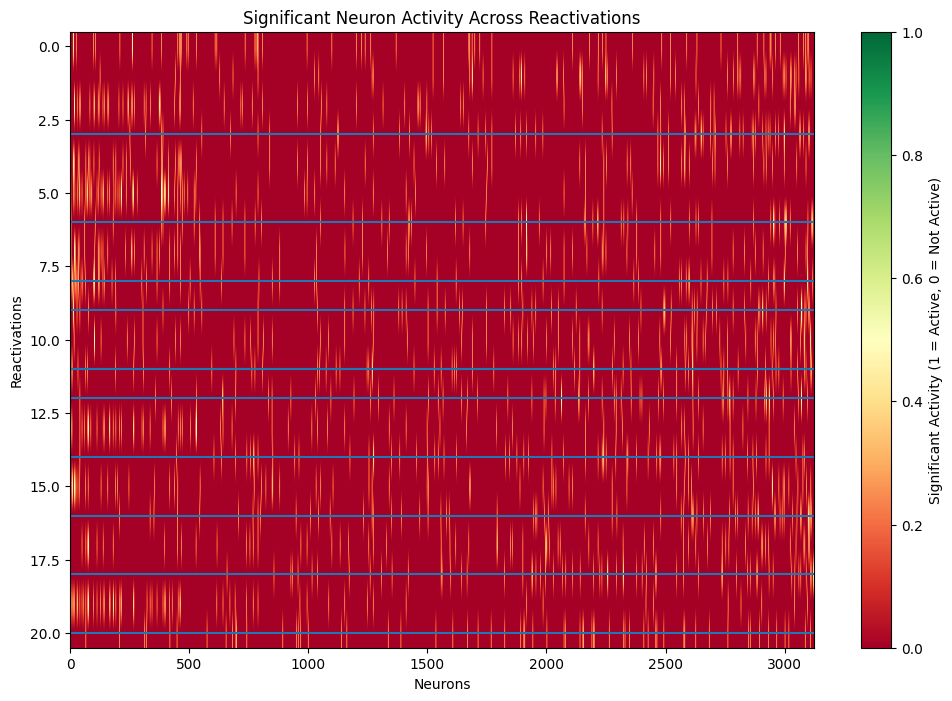

In [108]:
significant_neurons_list_r1 = analyze_significant_neurons(mean_activity_r_1, trials=21)
plot_significant_neurons(significant_neurons_list_r1, total_neurons=mean_activity_r_1.shape[1])


Reactivation 1: 32 significant neurons
Reactivation 2: 32 significant neurons
Reactivation 3: 32 significant neurons
Reactivation 4: 32 significant neurons
Reactivation 5: 32 significant neurons
Reactivation 6: 32 significant neurons
Reactivation 7: 32 significant neurons
Reactivation 8: 32 significant neurons
Reactivation 9: 32 significant neurons
Reactivation 10: 32 significant neurons
Reactivation 11: 32 significant neurons
Reactivation 12: 32 significant neurons
Reactivation 13: 32 significant neurons
Reactivation 14: 32 significant neurons
Reactivation 15: 32 significant neurons
Reactivation 16: 32 significant neurons
Reactivation 17: 32 significant neurons
Reactivation 18: 32 significant neurons
Reactivation 19: 32 significant neurons
Reactivation 20: 32 significant neurons
Reactivation 21: 32 significant neurons
Reactivation 22: 32 significant neurons
Reactivation 23: 32 significant neurons
Reactivation 24: 32 significant neurons
Reactivation 25: 32 significant neurons
Reactivat

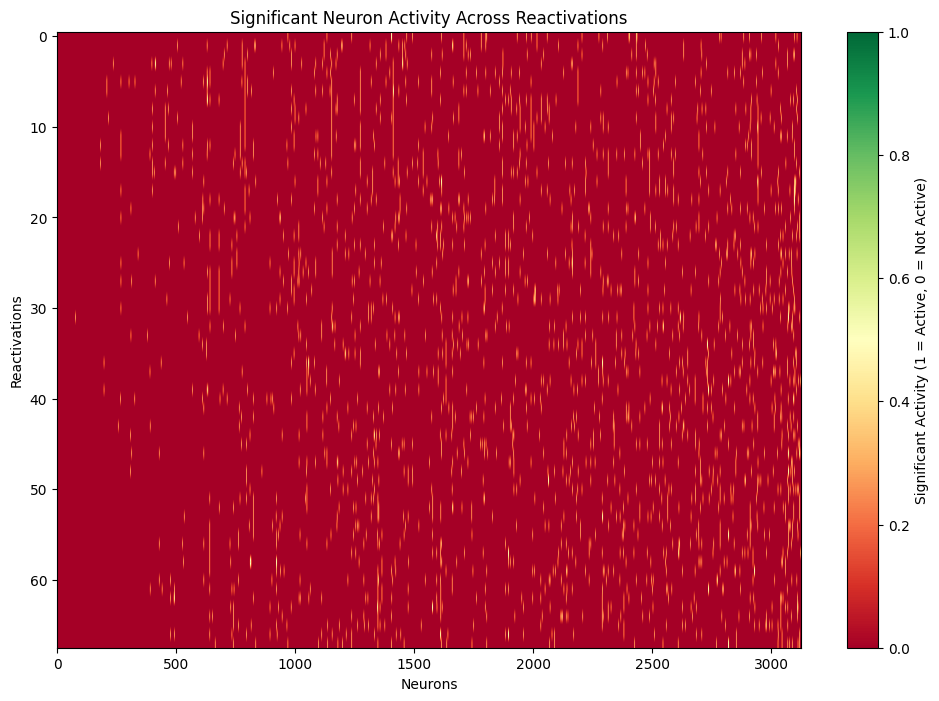

In [79]:
significant_neurons_list_cs1 = analyze_significant_neurons(mean_activity_cs_1, trials=mean_activity_cs_1.shape[0])
plot_significant_neurons(significant_neurons_list_cs1, total_neurons=mean_activity_r_1.shape[1])


In [109]:
# Flatten the array of arrays into a single set of unique neuron indices
unique_significant_neurons = np.unique(np.concatenate(significant_neurons_list_r1))

# Convert to a list if needed
unique_significant_neurons_list = unique_significant_neurons.tolist()

# Print the result
print("Unique significant neuron indices across all reactivations:")
print(len(unique_significant_neurons_list))


Unique significant neuron indices across all reactivations:
776


X_cs_1_sig shape: (139, 776)
y_cs_1_clean shape: (139, 3124)
Processed Targets for CS_1:
{0: 216563, 1: 217673}

=== Cross-Validation Summary ===
Accuracy:  0.797 ± 0.082
Precision: 0.794
Recall:    0.803
F1-score:  0.790


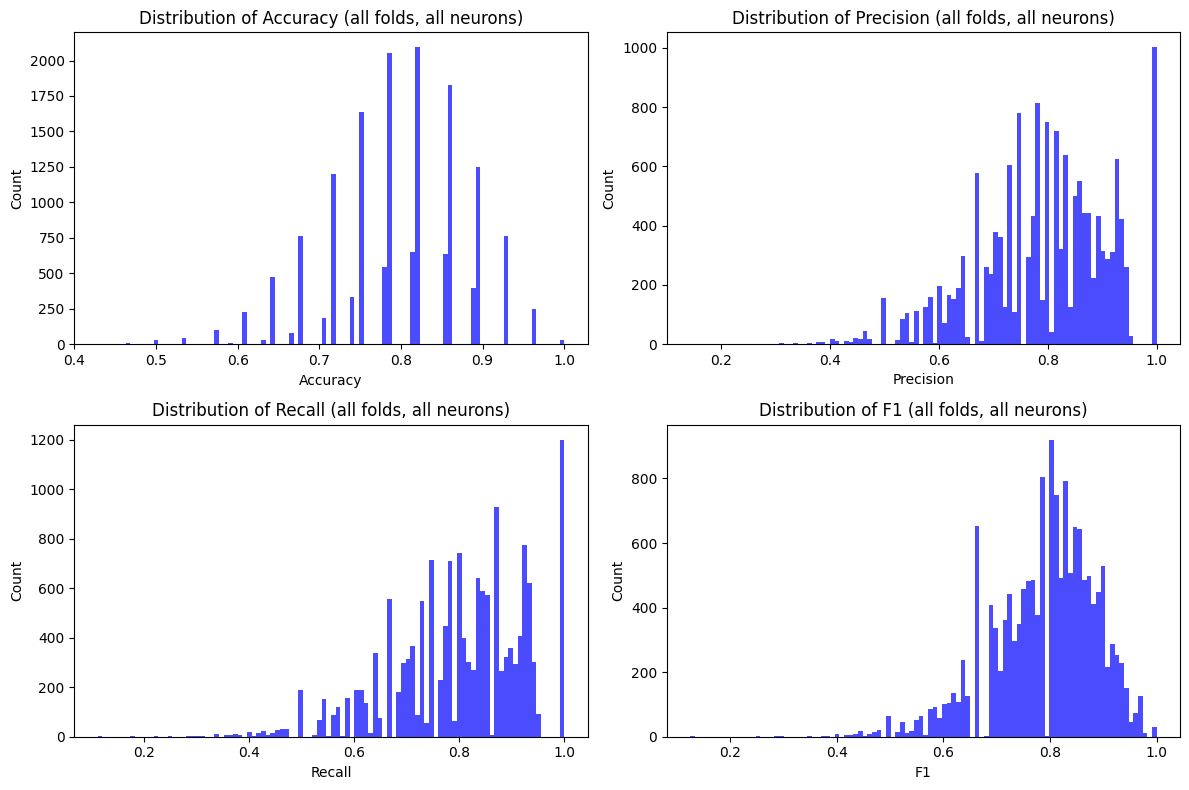

In [112]:
X_cs_1_sig, y_cs_1_clean_sig = clean_and_prepare_data(mean_activity_r_1[:, unique_significant_neurons], mean_activity_cs_1, trial_r_1)
# Sanity check the processed targets
unique_cs_1, counts_cs_1 = np.unique(y_cs_1_clean_sig, return_counts=True)

print(f"X_cs_1_sig shape: {X_cs_1_sig.shape}")  # Should be (139, unique_significant_neurons)
print(f"y_cs_1_clean shape: {y_cs_1_clean.shape}")  # Should be (139, total_neurons)

print("Processed Targets for CS_1:")
print(dict(zip(unique_cs_1, counts_cs_1)))

LR_model(X_cs_1_sig, y_cs_1_clean_sig)

X_cs_1_sig shape: (139, 669)
y_cs_1_clean shape: (139, 3124)
Processed Targets for CS_1:
{0: 216563, 1: 217673}

=== Cross-Validation Summary ===
Accuracy:  0.774 ± 0.083
Precision: 0.773
Recall:    0.782
F1-score:  0.767


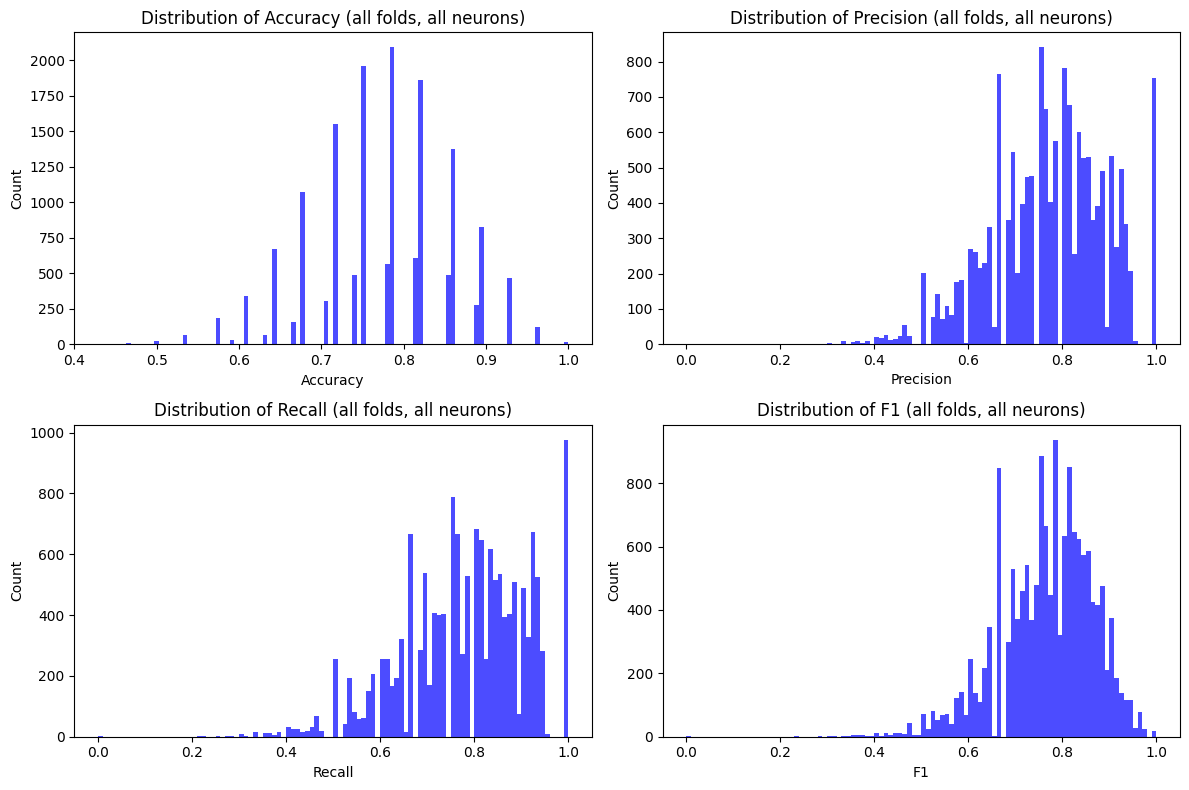

In [84]:
# Subset the predictors (X) using significant neurons
X_cs_1_sig, y_cs_1_clean = clean_and_prepare_data(
    mean_activity_r_1[:, unique_significant_neurons[1000:]],  # Predictors: subset of 500 neurons
    mean_activity_cs_1,                                      # Still include all trials for reactivation
    trial_r_1
)

# Sanity check the processed targets
unique_cs_1, counts_cs_1 = np.unique(y_cs_1_clean, return_counts=True)

print(f"X_cs_1_sig shape: {X_cs_1_sig.shape}")  # Should be (139, 500)
print(f"y_cs_1_clean shape: {y_cs_1_clean.shape}")  # Should be (139, total_neurons)

print("Processed Targets for CS_1:")
print(dict(zip(unique_cs_1, counts_cs_1)))

LR_model(X_cs_1_sig, y_cs_1_clean_sig)


X_cs_1_sig shape: (139, 500)
y_cs_1_clean shape: (139, 3124)
Processed Targets for CS_1:
{0: 216563, 1: 217673}

=== Cross-Validation Summary ===
Accuracy:  0.774 ± 0.085
Precision: 0.772
Recall:    0.783
F1-score:  0.768


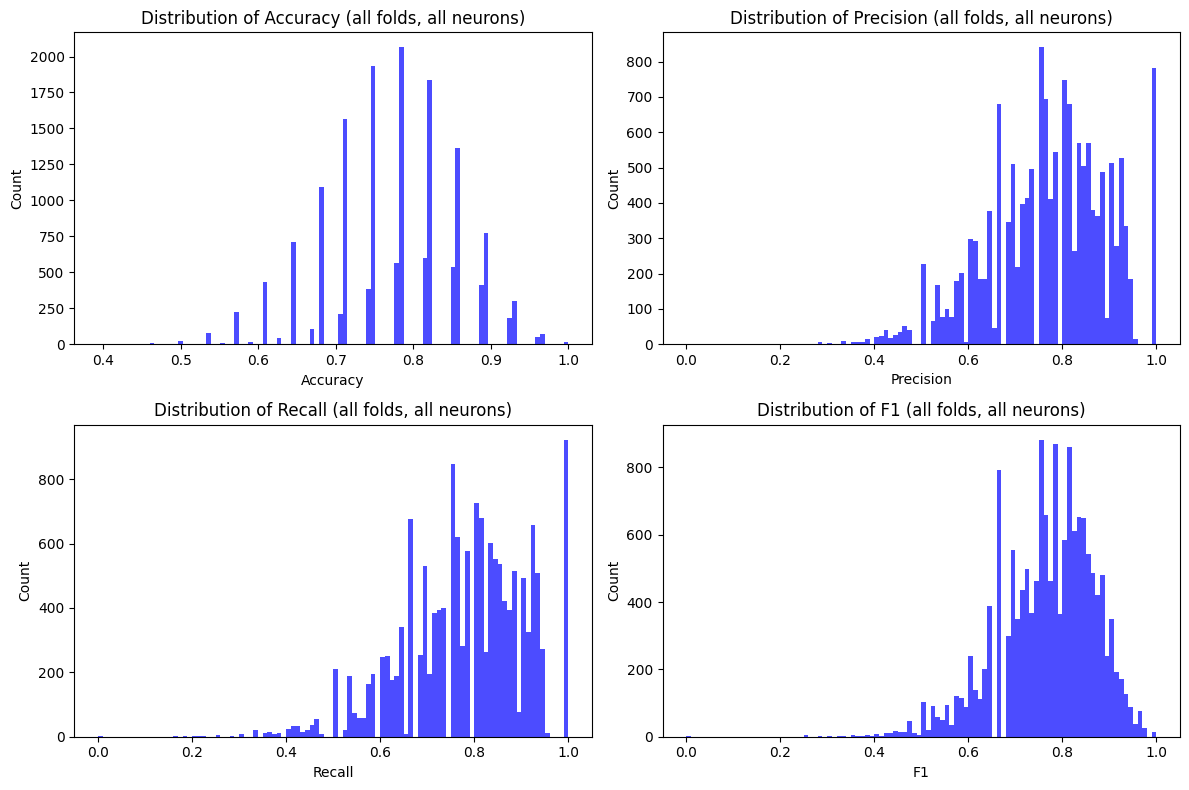

In [76]:
# Randomly sample 500 neurons
random_neuron_indices = np.random.choice(mean_activity_r_1.shape[1], size=500, replace=False)

# Subset the predictors (X) using the randomly selected neurons
X_cs_1_sig, y_cs_1_clean = clean_and_prepare_data(
    mean_activity_r_1[:, random_neuron_indices],  # Predictors: random subset of 500 neurons
    mean_activity_cs_1,                          # Trial-level activity
    trial_r_1                                    # Reactivation-to-trial mapping
)

# Sanity check the processed targets
unique_cs_1, counts_cs_1 = np.unique(y_cs_1_clean, return_counts=True)

print(f"X_cs_1_sig shape: {X_cs_1_sig.shape}")  # Should be (139, 500)
print(f"y_cs_1_clean shape: {y_cs_1_clean.shape}")  # Should be (139, total_neurons)

print("Processed Targets for CS_1:")
print(dict(zip(unique_cs_1, counts_cs_1)))

# Train the Logistic Regression model
LR_model(X_cs_1_sig, y_cs_1_clean)

Reactivation 1: 63 significant neurons
Reactivation 2: 63 significant neurons
Reactivation 3: 63 significant neurons
Reactivation 4: 63 significant neurons
Reactivation 5: 63 significant neurons
Reactivation 6: 63 significant neurons
Reactivation 7: 63 significant neurons
Reactivation 8: 63 significant neurons
Reactivation 9: 63 significant neurons
Reactivation 10: 63 significant neurons
Reactivation 11: 63 significant neurons
Reactivation 12: 63 significant neurons
Reactivation 13: 63 significant neurons
Reactivation 14: 63 significant neurons
Reactivation 15: 63 significant neurons
Reactivation 16: 63 significant neurons
Reactivation 17: 63 significant neurons
Reactivation 18: 63 significant neurons
Reactivation 19: 63 significant neurons
Reactivation 20: 63 significant neurons
Reactivation 21: 63 significant neurons
Overlap between reactivation 1 and 2: 10 / 63 neurons
Overlap between reactivation 2 and 3: 2 / 63 neurons
Overlap between reactivation 3 and 4: 2 / 63 neurons
Overlap b

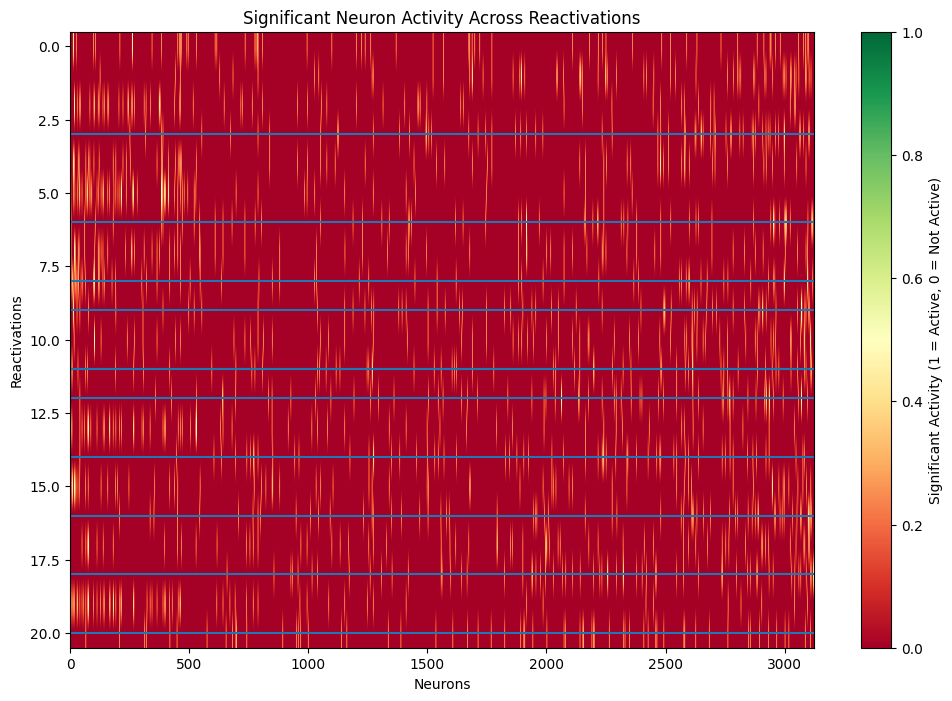

In [98]:
significant_neurons_list_r1_start = analyze_significant_neurons(mean_activity_r_1, trials=21)
plot_significant_neurons(significant_neurons_list_r1_start, total_neurons=mean_activity_r_1.shape[1])


Reactivation 1: 32 significant neurons
Reactivation 2: 32 significant neurons
Reactivation 3: 32 significant neurons
Reactivation 4: 32 significant neurons
Reactivation 5: 32 significant neurons
Reactivation 6: 32 significant neurons
Reactivation 7: 32 significant neurons
Reactivation 8: 32 significant neurons
Reactivation 9: 32 significant neurons
Reactivation 10: 32 significant neurons
Reactivation 11: 32 significant neurons
Overlap between reactivation 1 and 2: 5 / 32 neurons
Overlap between reactivation 2 and 3: 7 / 32 neurons
Overlap between reactivation 3 and 4: 6 / 32 neurons
Overlap between reactivation 4 and 5: 3 / 32 neurons
Overlap between reactivation 5 and 6: 6 / 32 neurons
Overlap between reactivation 6 and 7: 9 / 32 neurons
Overlap between reactivation 7 and 8: 6 / 32 neurons
Overlap between reactivation 8 and 9: 8 / 32 neurons
Overlap between reactivation 9 and 10: 12 / 32 neurons
Overlap between reactivation 10 and 11: 11 / 32 neurons

Summary of Similarity:
Average si

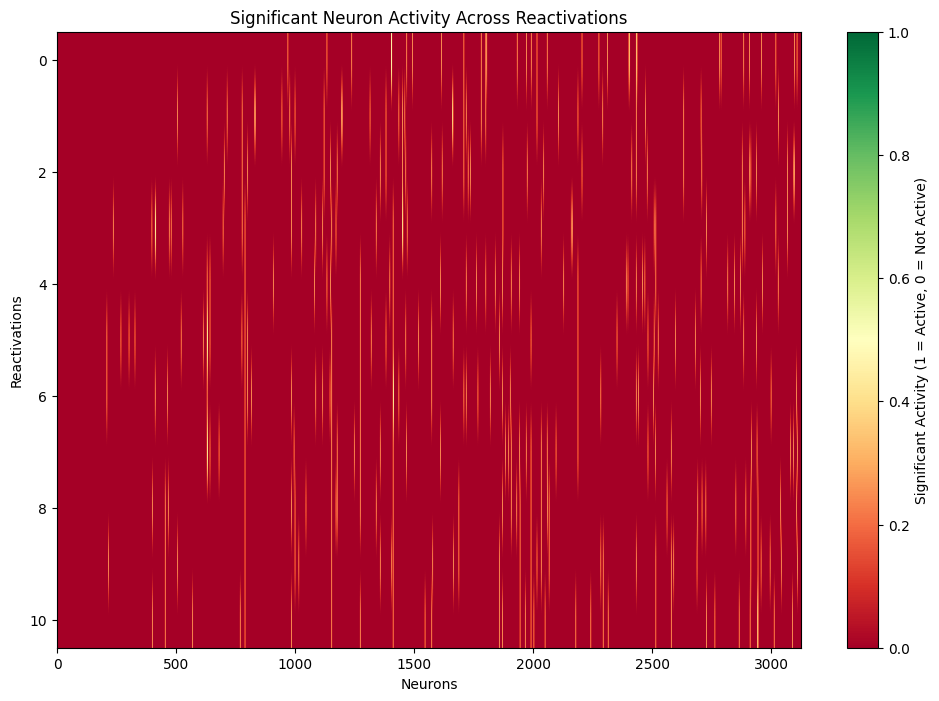

In [94]:
significant_neurons_list_cs1_start = analyze_significant_neurons(mean_activity_cs_1, trials=11)
plot_significant_neurons(significant_neurons_list_cs1_start, total_neurons=mean_activity_r_1.shape[1])


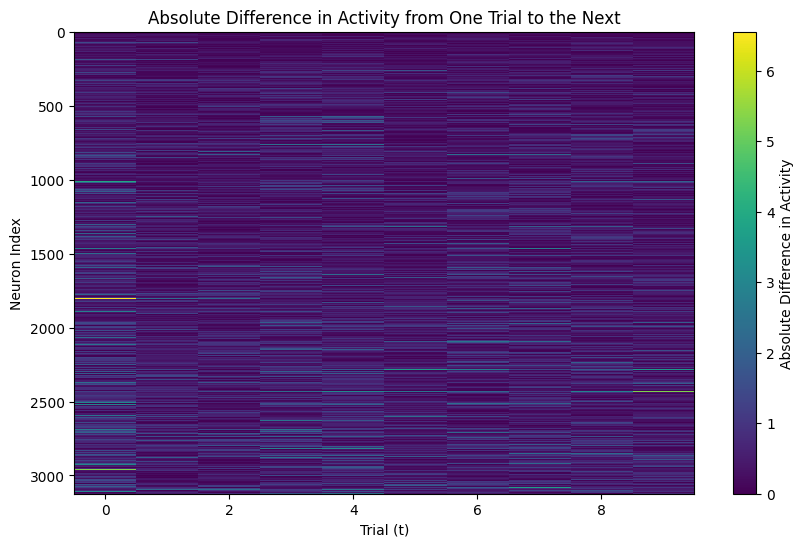

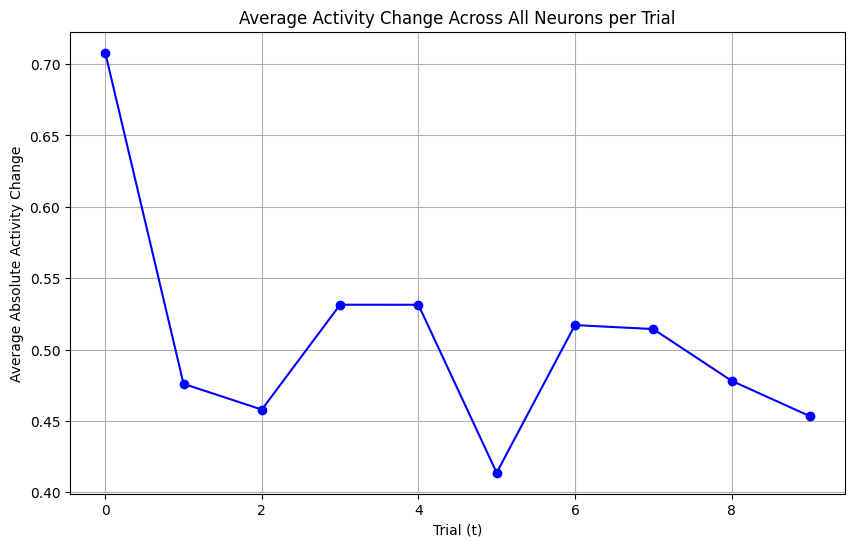

Average activity change across all neurons per trial:
[0.70797721 0.47594376 0.45791587 0.53139212 0.53134887 0.41366475
 0.51712627 0.51433985 0.47810348 0.45330687]


In [103]:
# Calculate absolute differences in activity from one trial to the next
absolute_differences = np.abs(np.diff(mean_activity_cs_1[0:11, ], axis=0))

# Calculate one number of activity change across all neurons (average change per trial)
average_activity_change = np.mean(absolute_differences, axis=1)  # Average across neurons for each trial

# Plotting the absolute differences
plt.figure(figsize=(10, 6))
plt.imshow(absolute_differences.T, aspect='auto', cmap='viridis', interpolation='nearest')
plt.colorbar(label='Absolute Difference in Activity')
plt.xlabel('Trial (t)')
plt.ylabel('Neuron Index')
plt.title('Absolute Difference in Activity from One Trial to the Next')
plt.show()

# Plot the average activity change per trial
plt.figure(figsize=(10, 6))
plt.plot(average_activity_change, marker='o', linestyle='-', color='blue')
plt.xlabel('Trial (t)')
plt.ylabel('Average Absolute Activity Change')
plt.title('Average Activity Change Across All Neurons per Trial')
plt.grid(True)
plt.show()

# Printing the average activity change
print("Average activity change across all neurons per trial:")
print(average_activity_change)


In [119]:
early_trials = slice(0, 3)  # rougly first 10% of trials
late_trials = slice(9, 11)  # rouglt last 10% of trials

# Compute average activity for early and late trials
mean_activity_cs1_early = mean_activity_cs_1[early_trials, :].mean(axis=0)  # Average over early trials
mean_activity_cs_1_late = mean_activity_cs_1[late_trials, :].mean(axis=0)  # Average over late trials

# Compute the change in activity
change_cs_1 = mean_activity_cs_1_late - mean_activity_cs1_early  # Late - Early for CS_1

# Rank neurons by change in activity
ranked_neurons_cs_1 = np.argsort(change_cs_1)[::-1]  # Descending order for CS_1

num_neurons = mean_activity_cs_1.shape[1]
top10_per = int(num_neurons * 0.05) #top10 percent of neurons
print(top10_per)

# Select the top neurons with the largest positive change
top_neurons_cs_1 = ranked_neurons_cs_1[:top10_per]  # Adjust number of top neurons as needed

# Subset the data for these neurons
cs1_top_learn_act = mean_activity_cs_1[:, top_neurons_cs_1]

bottom_neurons_cs_1 = ranked_neurons_cs_1[-top10_per:]

cs1_bott_learn_act = mean_activity_cs_1[:, bottom_neurons_cs_1]


print("Top neurons for CS_1:", len(top_neurons_cs_1))

# Combine top and bottom neurons for CS_1 and CS_2 and remove duplicates
cs1_neurons_combined = np.unique(np.concatenate([top_neurons_cs_1, bottom_neurons_cs_1]))

print(f"Number of unique neurons selected: {len(cs1_neurons_combined)}")


156
Top neurons for CS_1: 156
Number of unique neurons selected: 312


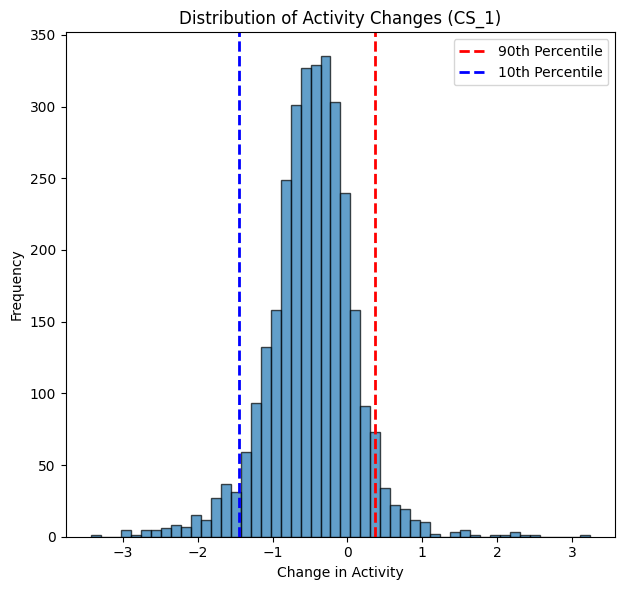

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


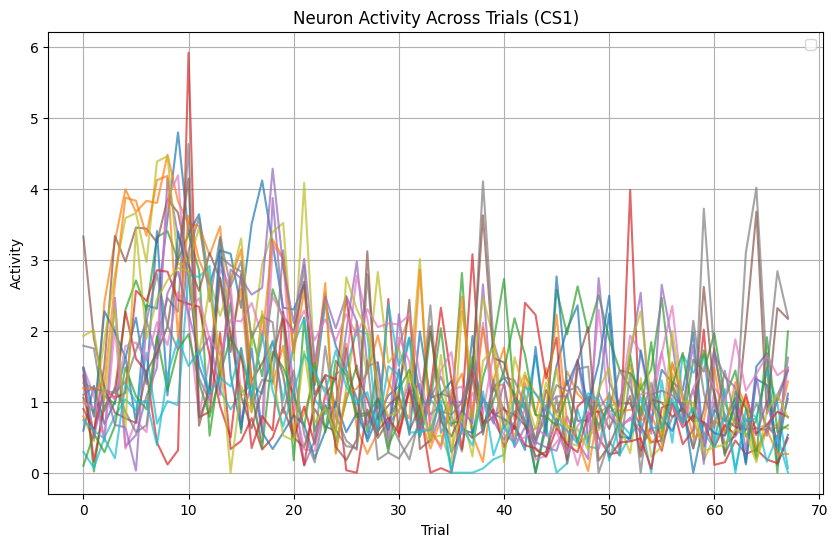

In [123]:
# Plot the distributions
plt.figure(figsize=(12, 6))

# CS_1
plt.subplot(1, 2, 1)
plt.hist(change_cs_1, bins=50, alpha=0.7, edgecolor='black')
plt.axvline(np.percentile(change_cs_1, 95), color='red', linestyle='dashed', linewidth=2, label='90th Percentile')
plt.axvline(np.percentile(change_cs_1, 5), color='blue', linestyle='dashed', linewidth=2, label='10th Percentile')
plt.title('Distribution of Activity Changes (CS_1)')
plt.xlabel('Change in Activity')
plt.ylabel('Frequency')
plt.legend()
plt.tight_layout()
plt.show()

# Select the first 5 neurons for scatter plotting
selected_neurons = 20

plt.figure(figsize=(10, 6))
for i in range(selected_neurons):
    plt.plot(range(cs1_top_learn_act.shape[0]), cs1_top_learn_act[:, i], alpha=0.7)

plt.title("Neuron Activity Across Trials (CS1)")
plt.xlabel("Trial")
plt.ylabel("Activity")
plt.legend()
plt.grid()
plt.show()



In [116]:
print(y_pred_log)

[array([[9.99965815e-01, 1.37927415e-05, 2.03918823e-05],
       [6.99736529e-52, 9.99998159e-01, 1.84093687e-06],
       [5.88151826e-09, 7.59553152e-01, 2.40446842e-01],
       ...,
       [2.86861942e-03, 7.02251926e-01, 2.94879454e-01],
       [1.05721640e-07, 4.02060022e-02, 9.59793892e-01],
       [4.00571128e-22, 9.99859968e-01, 1.40031648e-04]]), array([[9.99941032e-01, 1.63145368e-05, 4.26533766e-05],
       [3.85554386e-49, 1.00000000e+00, 1.36508435e-16],
       [1.83703985e-07, 9.69074809e-01, 3.09250076e-02],
       ...,
       [3.31126719e-03, 5.80887660e-01, 4.15801073e-01],
       [8.62835669e-07, 1.67539778e-01, 8.32459359e-01],
       [1.46492984e-18, 9.99986631e-01, 1.33691770e-05]]), array([[9.99854340e-01, 5.95698203e-05, 8.60901090e-05],
       [3.62722494e-29, 8.31651805e-01, 1.68348195e-01],
       [1.40392917e-06, 4.75743522e-01, 5.24255074e-01],
       ...,
       [5.63734738e-02, 7.41898532e-01, 2.01727995e-01],
       [5.18318138e-06, 3.45336877e-01, 6.54657